# Prepare training and validation data from labeled dataset

In this notebook, we will take the annotated dataset containing Raven-formatted annotation files, and prepare a table of labels that we can use to train a Convolutional Nerual Network (CNN) in OpenSoundscape. The format of the labels we want to create is a table with the audio file path, start and end time of 2-second audio segments (with 1.5 seconds of overlap between segments), and 0 (absent) or 1 (present) labels for each clip and each annotation 'A', 'B', 'C', 'D', 'E', or 'X'. 

To do this, we will use the BoxedAnnotations class in OpenSoundscape to load Raven-formatted annotations and convert them to one-hot labels. 

Then, we'll split our labeled data into training and validation sets for the CNN training phase.

In [2]:
import pandas as pd
from opensoundscape.annotations import BoxedAnnotations
from glob import glob
from pathlib import Path

specify the path of the downloaded dataset `rana_sierrae_2022` in this cell:

In [3]:
data_dir='/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022'

load the table that matches audio files with raven files

In [4]:
file_df=pd.read_csv(f'{data_dir}/audio_and_raven_files.csv')

Raven annotations are delimited in time with a start and end time. When creating labels for two-second clips, we will consider a clip to contain the annotation if either (1) at least 0.2 seconds of the annotation overlap with the clip (`min_label_overlap` argument), or (2) more than 50% of the annotation falls within this 2 second clip (`min_label_fraction` parameter). 

In [14]:
annotation_types = ['A','B','C','D','E','X']
all_annotations = []
for af, rf in zip(file_df.audio,file_df.raven):
    raven_path = f"{data_dir}/{rf}"
    ba = BoxedAnnotations.from_raven_file(raven_path,annotation_column='annotation',audio_file=af) 
    ba.df = ba.df.dropna() 
    if len(ba.df)>0:
        clip_df = ba.one_hot_clip_labels(
                               class_subset=annotation_types,
                               full_duration=10,
                               clip_duration=2,
                               clip_overlap=1.5,
                               min_label_overlap=0.2,
                               min_label_fraction=0.5,
                            ).astype(int)
        #we will add the full path of the audio file for eas of use later
        clip_df['file']=f"{data_dir}/{af}"
        clip_df = clip_df.reset_index().set_index(['file','start_time','end_time'])
        all_annotations.append(clip_df)
labels = pd.concat(all_annotations)

/Users/SML161/miniconda3/envs/opso080/lib/python3.9/site-packages/opensoundscape/annotations.py:539: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "overlap"] = [
/Users/SML161/miniconda3/envs/opso080/lib/python3.9/site-packages/opensoundscape/annotations.py:539: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "overlap"] = [
/Users/SML161/miniconda3/envs/opso080/lib/python3.9/site-packages/opensoundscape/annotations.py:539: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of

We now have a table of one-hot labels for 2-second audio segments. Let's check the number of clips containing each annotation type:

In [15]:
labels.sum()

A    2678
B     117
C     506
D     355
E     726
X     621
dtype: int64

Let's look at a random selection of 5 rows from our one-hot label dataframe:

In [16]:
labels.sample(5,random_state=2023)

,,,A,B,C,D,E,X
file,start_time,end_time,,,,,,
/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220626_050000_0-10s.mp3,6.5,8.5,1,0,0,0,1,0
/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220620_063000_0-10s.mp3,6.0,8.0,1,0,0,0,0,0
/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220626_050000_0-10s.mp3,5.5,7.5,1,0,0,0,0,0
/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220625_173000_0-10s.mp3,0.5,2.5,0,0,0,0,0,0
/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220620_101500_0-10s.mp3,6.0,8.0,0,0,0,0,0,0


## Include A and E classes, and exclude clips with uncertainty from training and validation
We want to train a CNN to detect vocalization types A and E. If a 2-second clip has the X (uncertain) label and does not have an A or E label, we will exclude the clip from training and validation (since we are uncertain if it contains the target classes). 

In [22]:
import numpy as np
#choose training and validation labels: clips labeled with A or E
labels['ramu']=np.logical_or(labels.A,labels.E).astype(int)

# drop clips with 0 for ramu and 1 for 'X' unsure class
labels = labels.drop(labels[(labels.ramu==0) & (labels.X==1)].index)

## Split labeled files into train and validation sets

We want to make sure a 10 second file is included entirely in the training or validation set, rather than being split across the two sets. Therefore, we perform a random split on the list of audio files, retaining 10% as validation and using the other 90% for training. 

In [28]:
from sklearn.model_selection import train_test_split

train_files,val_files = train_test_split(labels.reset_index().file.unique(),test_size=0.1,random_state=20221208)

# subset the labels for training and validation based on the file lists
train_df = labels.reset_index().set_index('file').loc[train_files][['start_time','end_time','ramu']]
val_df = labels.reset_index().set_index('file').loc[val_files][['start_time','end_time','ramu']]

In [29]:
train_df.to_csv('./resources/training_set.csv')
val_df.to_csv('./resources/validation_set.csv')

# Sanity check: look at a labeled clip

Let's check out the audio and spectrogram of a a clip that contains the labels 'A' and 'E'

In [41]:
from opensoundscape import Audio, Spectrogram
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'
from opensoundscape.annotations import BoxedAnnotations

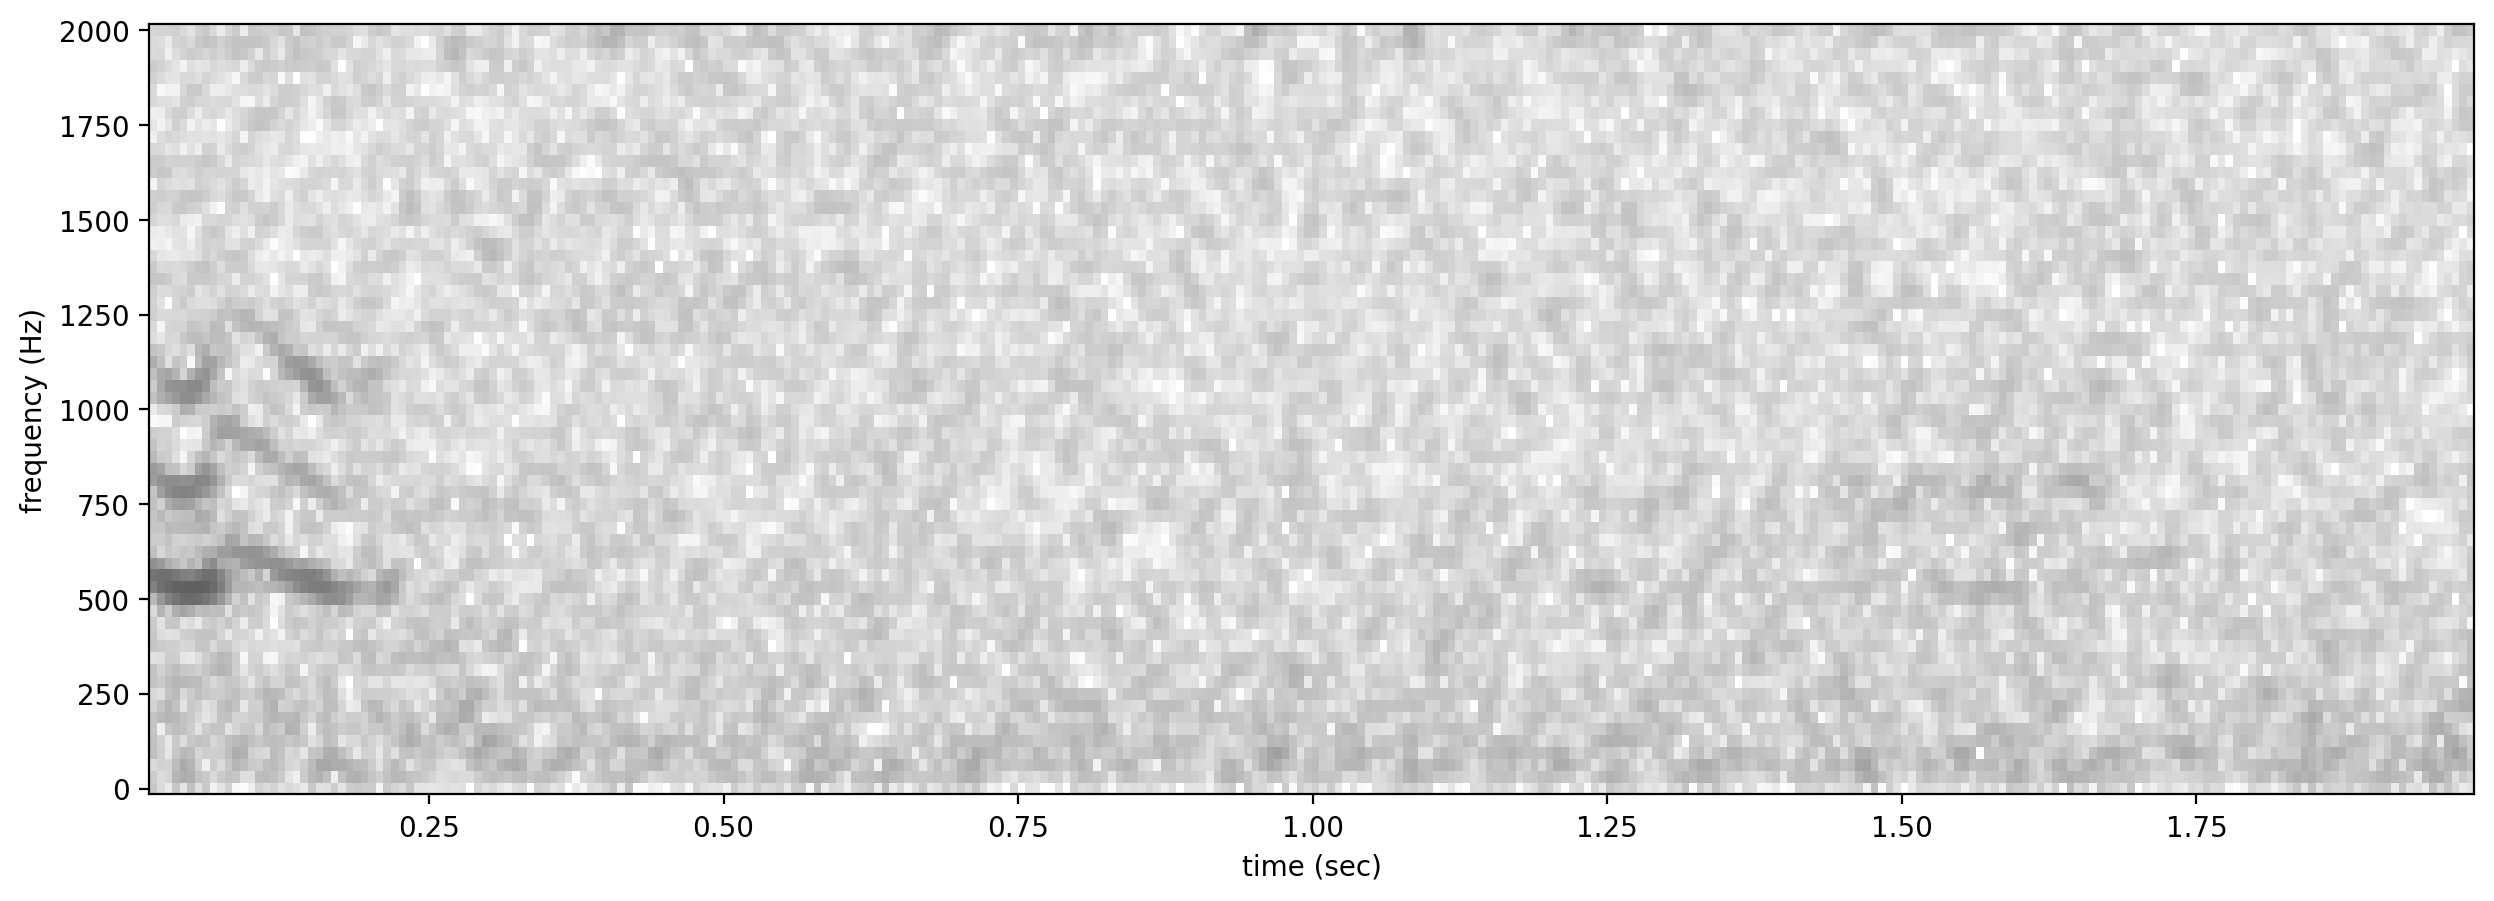

In [42]:
audio_path = labels.sample(5,random_state=2023).index.values[2][0]
audio=Audio.from_file(audio_path,offset=6.5,duration=2)
Spectrogram.from_audio(audio,window_samples=1024,overlap_fraction=0.8).bandpass(0,2000).plot()

we can see a loud A vocalization and a faint E vocalization to the right